
Data preprocessing        
Output: data/data_final.h5ad

@authors: Melnikas, Max; Nkambule, Lethukuthula; Wan, Guihong        
@date: Oct 12, 2024       

In [39]:
import anndata as ad
import numpy as np
import scimap as sm
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import scanpy as sc
warnings.filterwarnings("ignore")

## read and process data

In [40]:
adata_org = ad.read_h5ad("data/Z147_1_750.h5ad")

In [41]:
############
# Sampling
############
n_samples = 10000 # Define the number of samples you want
n_obs = adata_org.n_obs # Number of observations (cells) in the dataset
# Ensure the sample size does not exceed the number of available observations
if n_samples > n_obs:
    raise ValueError("Number of samples requested exceeds the number of available observations.")

# Generate random indices for sampling
random_indices = np.random.choice(n_obs, n_samples, replace=False)

# Subset the AnnData object using the random indices
adata = adata_org[random_indices, :]

# Print the shape to confirm the subset process
print(adata.shape)

(10000, 30)


In [42]:
############
# Merge T cells
############

adata.obs['phenotype'] = adata.obs['phenotype'].astype('category')
# T cell categories you want to merge
t_cell_categories = [
    "T cells", "Terminally Exhausted T cells", "Patially Exhausted T cells", 
    "Regulatory T cells", "Cytotoxic T cells"
]
# Update
adata.obs['phenotype'] = adata.obs['phenotype'].replace(t_cell_categories, "T cells")

print(adata.obs['phenotype'].value_counts())

phenotype
Tumor                 4617
Unknown               1676
Myeloid Lineage       1197
Myofibroblast          586
Blood Vessels          535
T cells                492
APCs                   332
Macrophages            213
CD11C+ PDL1+ cells     127
Keratinocytes          123
Melanocytes             68
Mast cells              29
Langerhan cells          5
Name: count, dtype: int64


In [43]:
############
# Remove data to make the file small
############
print(adata.obs_keys)

columns_to_keep = ['X_centroid', 'Y_centroid', 'phenotype']
adata.obs = adata.obs[columns_to_keep]
print(adata.obs_keys)

<bound method AnnData.obs_keys of AnnData object with n_obs × n_vars = 10000 × 30
    obs: 'X_centroid', 'Y_centroid', 'column_centroid', 'row_centroid', 'Area', 'MajorAxisLength', 'MinorAxisLength', 'Eccentricity', 'Solidity', 'Extent', 'Orientation', 'imageid', 'phenotype', 'kmeans', 'kmeans_renamed', 'pickseq_roi', 'pickseq_roi_minimal', 'dermis_roi', 'epidermis_roi', 'general_roi', 'Kmeans_r', 'der_epider_roi', 'phenotype_proliferation', 'phenograph', 'spatial_expression_phenograph', 'spatial_expression_kmeans', 'phenograph_raw', 'phenograph_raw_minimal', 'phenotype_1', 'phenotype_1_tumor_kmeans', 'phenotype_1_tumor_kmeans_renamed', 'phenotype_final', 'spatial_expression_consolidated', 'MC', 'spatial_count_kmeans', 'phenotype_2', 'phenotype_2_tumor_kmeans', 'phenotype_2_tumor_kmeans_renamed', 'phenotype_large_cohort', 'phenotype_large_cohort_RJP', 'spatial_lda_kmeans', 'phenotype_2_tumor_kmeans_old', 'tumor_expression_trimmed', 'tumor_expression_TC', 'IM_roi', 'TC_ROI_IM_large', 'T

In [44]:
print(adata.var.index)
markers_to_keep = ["KERATIN", "SOX10", "CD3D", "C8A", "CD1A", "CD163", "MITF", "CD11C","CD63"]
adata = adata[:, adata.var.index.isin(markers_to_keep)]
print(adata.var.index)

Index(['HHLA2', 'CMA1', 'SOX10', 'S100B', 'KERATIN', 'CD1A', 'CD163', 'CD3D',
       'C8A', 'MITF', 'FOXP3', 'PDL1', 'KI67', 'LAG3', 'TIM3', 'PCNA',
       'pSTAT1', 'cPARP', 'SNAIL', 'aSMA', 'HLADPB1', 'S100A', 'CD11C', 'PD1',
       'LDH', 'PANCK', 'CCNA2', 'CCND1', 'CD63', 'CD31'],
      dtype='object')
Index(['SOX10', 'KERATIN', 'CD1A', 'CD163', 'CD3D', 'C8A', 'MITF', 'CD11C',
       'CD63'],
      dtype='object')


In [45]:
# First three observations look like
print(adata.obs.head(3))

                       X_centroid    Y_centroid        phenotype
unmicst-1_750_755218  6671.429907  15392.682243            Tumor
unmicst-1_750_767327  8369.787879  15536.393939            Tumor
unmicst-1_750_497616  3468.256098  12574.735772  Myeloid Lineage


In [46]:
# Data Shape
adata[list(adata.obs_names),:].X.shape

(10000, 9)

In [47]:
keys_to_remove = ["dendrogram_['kmeans']", "dendrogram_['phenograph']", "dendrogram_['phenograph_raw']", "dendrogram_['phenograph_raw_minimal']", "dendrogram_['phenotype']", "dendrogram_['phenotype_2_tumor_kmeans']", "dendrogram_['phenotype_2_tumor_kmeans_scaled']", "dendrogram_['spatial_expression_consolidated']", "dendrogram_['spatial_expression_kmeans']", "dendrogram_['spatial_expression_phenograph']", 'interaction_all', 'rank_genes_groups', 'spatial_count_radius', 'spatial_distance', 'spatial_expression_radius', 'spatial_interaction', 'spatial_interaction_1', 'spatial_interaction_motif_analysis', 'tsne', 'leiden_colors']

# Remove the specified keys from the .uns attribute
for key in keys_to_remove:
    if key in adata.uns:
        del adata.uns[key]

In [48]:
adata

View of AnnData object with n_obs × n_vars = 10000 × 9
    obs: 'X_centroid', 'Y_centroid', 'phenotype'
    uns: 'all_markers', "dendrogram_['kmeans']", "dendrogram_['phenograph']", "dendrogram_['phenograph_raw']", "dendrogram_['phenograph_raw_minimal']", "dendrogram_['phenotype']", "dendrogram_['phenotype_2_tumor_kmeans']", "dendrogram_['phenotype_2_tumor_kmeans_scaled']", "dendrogram_['spatial_expression_consolidated']", "dendrogram_['spatial_expression_kmeans']", "dendrogram_['spatial_expression_phenograph']", 'interaction_all', 'rank_genes_groups', 'spatial_count_radius', 'spatial_distance', 'spatial_expression_radius', 'spatial_interaction', 'spatial_interaction_1', 'spatial_interaction_motif_analysis'

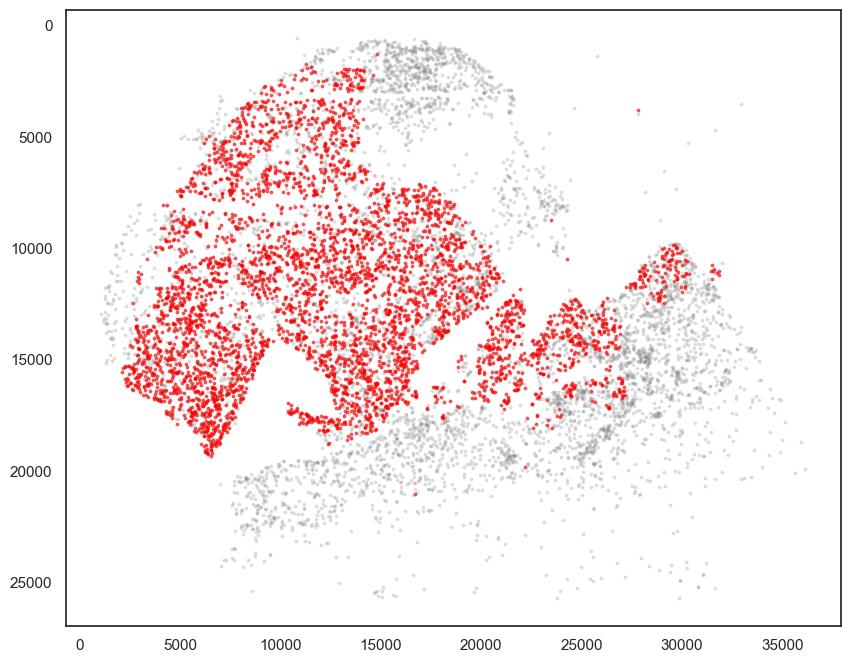

In [49]:
# Plot

fig, ax = plt.subplots(figsize=(10, 8))
# All cells shown in grey for background
ax.scatter(
    *zip(*adata.obs[["X_centroid", "Y_centroid"]].to_numpy()),
    s=3,
    color="grey",
    alpha=0.2
)
# tumor cells
ax.scatter(
    *zip(*adata[adata.obs["phenotype"] == "Tumor"].obs[["X_centroid", "Y_centroid"]].to_numpy()),
    s=3,
    color="red",
    alpha=0.5
)

ax.invert_yaxis()

### Clustering
#### Leiden Clustering

In [50]:
adata = sm.tl.cluster(adata, method='leiden', resolution=0.3, use_raw=False, log=False)
adata.obs['leiden'].value_counts()

Leiden clustering


leiden
0    3231
1    2551
2    1623
3    1599
4     894
5     102
Name: count, dtype: int64

#### KMean Clustering

In [51]:
adata = sm.tl.cluster(adata, method='kmeans', k=6, use_raw=False, log=False)
adata.obs['kmeans'].value_counts()

Kmeans clustering


kmeans
2    3003
3    2110
1    1880
5    1235
0     981
4     791
Name: count, dtype: int64

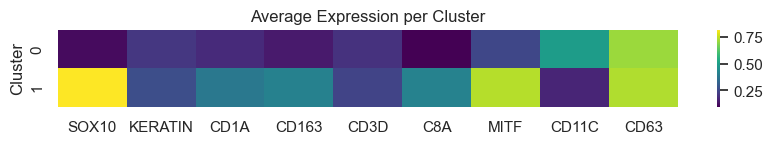

In [52]:
cluster_method = "kmeans"
cluster_of_interest = ['0','1']

adata_cluster = adata[adata.obs[cluster_method].isin(cluster_of_interest)]
cluster_means = adata_cluster.to_df().groupby(adata_cluster.obs[cluster_method]).mean()

plt.figure(figsize=(10, 0.5*len(cluster_of_interest)))
sns.heatmap(cluster_means, cmap='viridis', robust=True)
plt.title("Average Expression per Cluster")
plt.ylabel("Cluster")
plt.show()


### Dimension Reduction

#### UMAP

In [53]:
# Basic UMAP reduction
adata = sm.tl.umap(adata, n_neighbors=15, min_dist=0.1)
adata

AnnData object with n_obs × n_vars = 10000 × 9
    obs: 'X_centroid', 'Y_centroid', 'phenotype', 'leiden', 'kmeans'
    uns: 'all_markers', "dendrogram_['kmeans']", "dendrogram_['phenograph']", "dendrogram_['phenograph_raw']", "dendrogram_['phenograph_raw_minimal']", "dendrogram_['phenotype']", "dendrogram_['phenotype_2_tumor_kmeans']", "dendrogram_['phenotype_2_tumor_kmeans_scaled']", "dendrogram_['spatial_expression_consolidated']", "dendrogram_['spatial_expression_kmeans']", "dendrogram_['spatial_expression_phenograph']", 'interaction_all', 'rank_genes_groups', 'spatial_count_radius', 'spatial_distance', 'spatial_expression_radius', 'spatial_interaction', 'spatial_interaction_1', 'spatial_interaction_motif_analysis'
    obsm: 'umap'

#### t-SNE

In [54]:
sc.tl.tsne(adata)
adata

AnnData object with n_obs × n_vars = 10000 × 9
    obs: 'X_centroid', 'Y_centroid', 'phenotype', 'leiden', 'kmeans'
    uns: 'all_markers', "dendrogram_['kmeans']", "dendrogram_['phenograph']", "dendrogram_['phenograph_raw']", "dendrogram_['phenograph_raw_minimal']", "dendrogram_['phenotype']", "dendrogram_['phenotype_2_tumor_kmeans']", "dendrogram_['phenotype_2_tumor_kmeans_scaled']", "dendrogram_['spatial_expression_consolidated']", "dendrogram_['spatial_expression_kmeans']", "dendrogram_['spatial_expression_phenograph']", 'interaction_all', 'rank_genes_groups', 'spatial_count_radius', 'spatial_distance', 'spatial_expression_radius', 'spatial_interaction', 'spatial_interaction_1', 'spatial_interaction_motif_analysis', 'tsne'
    obsm: 'umap', 'X_tsne'

In [55]:
print(adata.obsm["X_tsne"].shape)
print(adata.obsm["umap"].shape)

(10000, 2)
(10000, 2)


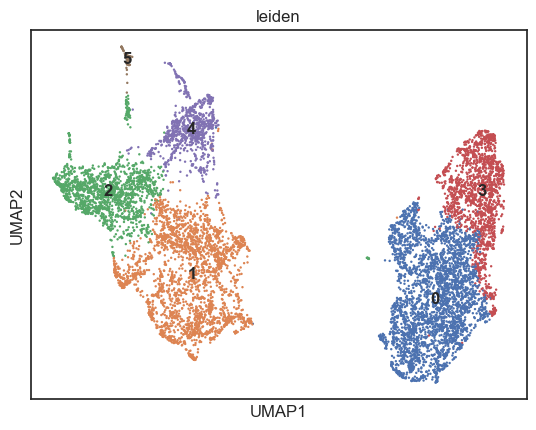

In [56]:
sc.pl.umap(adata, color='leiden', legend_loc='on data')

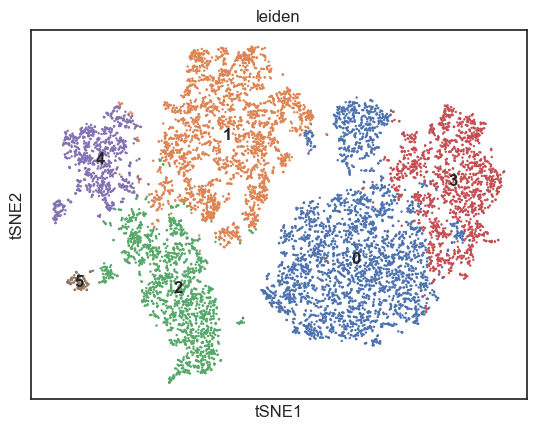

In [57]:
sc.pl.tsne(adata, color='leiden', legend_loc='on data')

In [59]:
adata

AnnData object with n_obs × n_vars = 10000 × 9
    obs: 'X_centroid', 'Y_centroid', 'phenotype', 'leiden', 'kmeans'
    uns: 'all_markers', "dendrogram_['kmeans']", "dendrogram_['phenograph']", "dendrogram_['phenograph_raw']", "dendrogram_['phenograph_raw_minimal']", "dendrogram_['phenotype']", "dendrogram_['phenotype_2_tumor_kmeans']", "dendrogram_['phenotype_2_tumor_kmeans_scaled']", "dendrogram_['spatial_expression_consolidated']", "dendrogram_['spatial_expression_kmeans']", "dendrogram_['spatial_expression_phenograph']", 'interaction_all', 'rank_genes_groups', 'spatial_count_radius', 'spatial_distance', 'spatial_expression_radius', 'spatial_interaction', 'spatial_interaction_1', 'spatial_interaction_motif_analysis', 'tsne', 'leiden_colors'
    obsm: 'umap', 'X_tsne'

In [58]:
adata.write("data/data_final.h5ad")